In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

import preprocessing
import algorithms
import plots

In [2]:
DATA_PATH_1 = Path("../data/data1.mat")
DATA_PATH_2 = Path("../data/data2.mat")
DATA_PATH_3 = Path("../data/movies.mat")
DATA_PATH_4 = Path("../data/movieParams.mat")
DATA_PATH_5 = Path("../data/movie_ids.txt")

# Part 1

## Anomaly detection
In this exercise, you will implement an anomaly detection algorithm to detect anomalous behavior in server computers. The features measure the throughput (mb/s) and latency (ms) of response of each server. While your servers were operating, you collected m = 307 examples of how they were behaving, and thus have an unlabeled dataset $\{x^{(1)} , . . . , x^{(m)}\}$. You suspect that the vast majority of these examples are “normal” (non-anomalous) examples of the servers operating normally, but there might also be some examples of servers acting anomalously within this dataset.

You will use a Gaussian model to detect anomalous examples in your dataset. You will first start on a 2D dataset that will allow you to visualize what the algorithm is doing. On that dataset you will fit a Gaussian distribution and then find values that have very low probability and hence can be considered anomalies. After that, you will apply the anomaly detection algorithm to a larger dataset with many dimensions.

In [3]:
x, x_val, y_val = preprocessing.read_data(
    DATA_PATH_1, column_names=["X", "Xval", "yval"]
)

## Dataset Visualization
The first part of ex8.m will visualize the dataset.

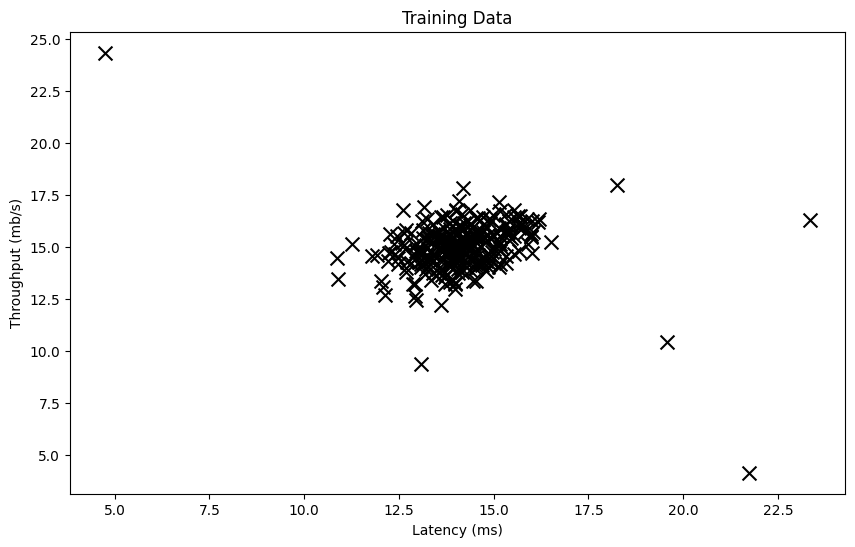

In [4]:
plots.scatter(x[:, 0], x[:, 1], x_label="Latency (ms)", y_label="Throughput (mb/s)")

## Gaussian distribution
To perform anomaly detection, you will first need to fit a model to the data’s
distribution.

Given a training set $\{x^{(1)} , . . . , x^{(m)}\}$(where $x(i) \ R^n $), you want to estimate the Gaussian distribution for each of the features $x_i$ . For each feature $i = 1 . . . n$, you need to find parameters $\mu_i$ and $\sigma_i^2$ that fit the data in the i-th dimension $\{x_i^{(1)} , . . . , x_i^{(m)}\}$ (the i-th dimension of each example).

The Gaussian distribution is given by

$$ p(x;\mu;\sigma^2)= \frac{1}{\sqrt{2 \pi \sigma^2}}e^{-\frac{(x-\mu)^2}{2\sigma^2}}$$

where $\mu$ is the mean and $\sigma^2$ controls the variance.

### Estimating parameters for a Gaussian
You can estimate the parameters, $(\mu_i , \sigma_i^2 )$, of the i-th feature by using the
following equations. To estimate the mean, you will use:

$$\mu_i = \frac{1}{m}\sum_{j=1}^m x_i^{(j)}$$

and for the variance you will use:

$$\sigma_i^2 = \frac{1}{m} \sum_{j=1}^m(x_i^{(j)}-\mu_i)^2$$

Your task is to complete the code in estimateGaussian.m. This function takes as input the data matrix X and should output an n-dimension vector mu that holds the mean of all the n features and another n-dimension vector sigma2 that holds the variances of all the features. You can implement this using a for-loop over every feature and every training example (though a vectorized implementation might be more efficient; feel free to use a vectorized implementation if you prefer).

Once you have completed the code in estimateGaussian.m, the next part of ex8.m will visualize the contours of the fitted Gaussian distribution. You should get a plot similar to Figure 2. From your plot, you can see that most of the examples are in the region with the highest probability, while the anomalous examples are in the regions with lower probabilities.

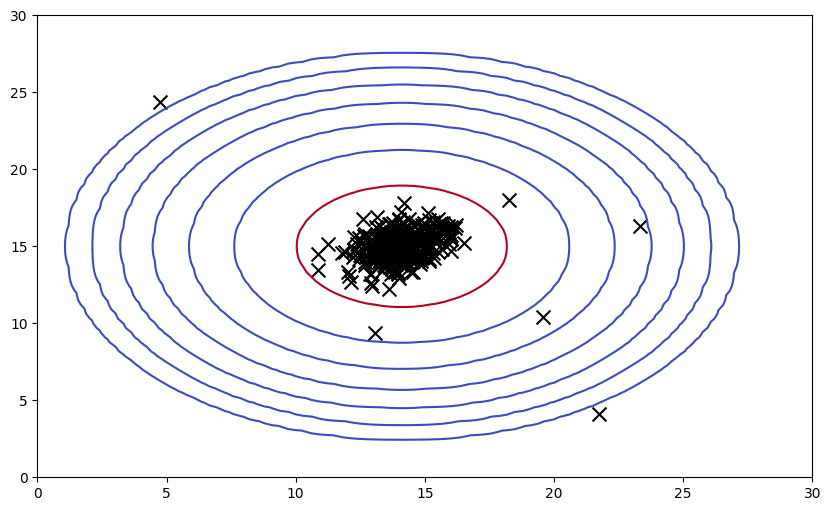

In [5]:
model = algorithms.GaussianRegression.from_array(x)
plots.plot_gaussian_contours(model, x, 0, 30, 0, 30)

## Selecting the threshold, $\epsilon$
Now that you have estimated the Gaussian parameters, you can investigate which examples have a very high probability given this distribution and which examples have a very low probability. The low probability examples are more likely to be the anomalies in our dataset. One way to determine which examples are anomalies is to select a threshold based on a cross validation set. In this part of the exercise, you will implement an algorithm to select the threshold $\epsilon$ using the F1 score on a cross validation set.

You should now complete the code in selectThreshold.m. For this, we will use a cross validation set $\{(x_{cv}^{(1)} , y_{cv}^{(1)} ), . . . , (x_{cv}^{(m_cv)} , y_{cv}^{(m_cv)} )\}$, where the label y = 1 corresponds to an anomalous example, and y = 0 correspondsto a normal example. For each cross validation example, we will compute $p(x_{cv}^{(i)})$. The vector of all of these probabilities $p(x_{cv}^{(1)}), . . . , p(x_{cv}^{(m_cv)}) )$ is passed to selectThreshold.m in the vector pval. The corresponding labels $y_{cv}^{(1)} , . . . , y_{cv}^{(m_cv)}$  is passed to the same function in the vector yval.

The function selectThreshold.m should return two values; the first is the selected threshold $\epsilon$. If an example x has a low probability $p(x) < \epsilon$, then it is considered to be an anomaly. The function should also return the F1 score, which tells you how well you’re doing on finding the ground truth anomalies given a certain threshold. For many different values of $\epsilon$, you will compute the resulting F1 score by computing how many examples the current threshold classifies correctly and incorrectly. The F1 score is computed using precision (prec) and recall (rec):

$$F_1 = \frac{2 \cdot prec \cdot rec}{prec + rec}$$

You compute precision and recall by:

$$ prec = \frac{tp}{tp + fp}$$

$$ rec = \frac{tp}{tp + fn}$$

where
* $tp$ is the number of true positives: the ground truth label says it’s an anomaly and our algorithm correctly classified it as an anomaly.
* $fp$ is the number of false positives: the ground truth label says it’s not an anomaly, but our algorithm incorrectly classified it as an anomaly.
* $fn$ is the number of false negatives: the ground truth label says it’s an anomaly, but our algorithm incorrectly classified it as not being anomalous.

In the provided code selectThreshold.m, there is already a loop that will try many different values of $\epsilon$ and select the best $\epsilon$ based on the F1 score. You should now complete the code in selectThreshold.m. You can implement the computation of the F1 score using a for-loop over all the cross validation examples (to compute the values tp, fp, fn). You should see a value for epsilon of about $8.99e-05$.

In [6]:
best_eps, best_f1 = model.select_threshold(x_val, y_val)

# The expected value of epsilon is  8.99e-05.
print(f"f1 score: {best_f1:.2f}, epsilon: {best_eps:.5e}")

f1 score: 0.88, epsilon: 8.99985e-05


## Plot the anomalies
Once you have completed the code in selectThreshold.m, the next step in ex8.m will run your anomaly detection code and circle the anomalies in the plot.

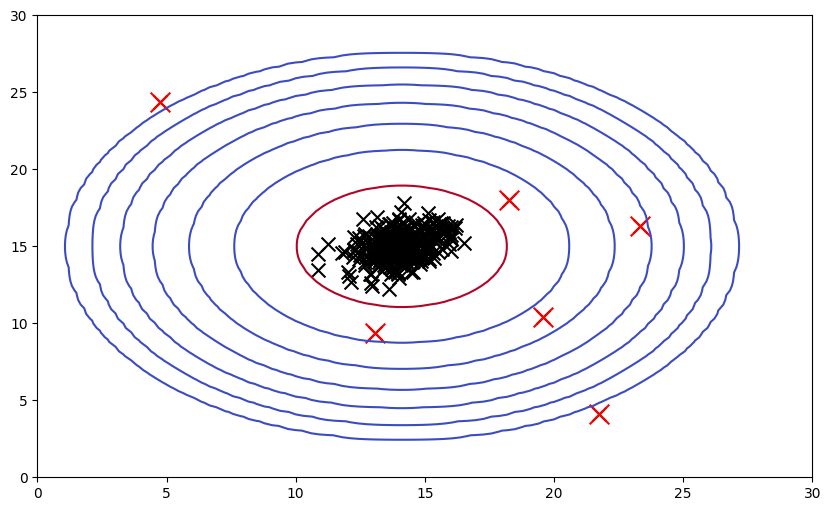

In [7]:
plots.plot_anomalies(model, x, 0, 30, 0, 30)

# Part 2

## High dimensional dataset
The last part of the script ex8.m will run the anomaly detection algorithm you implemented on a more realistic and much harder dataset. In this dataset, each example is described by 11 features, capturing many more properties of your compute servers.

The script will use your code to estimate the Gaussian parameters ($\mu_i$ and $\sigma_i^2$ ), evaluate the probabilities for both the training data X from which you estimated the Gaussian parameters, and do so for the the cross-validation set Xval. Finally, it will use selectThreshold to find the best threshold $\epsilon$. You should see a value epsilon of about 1.38e-18, and 117 anomalies found.

In [8]:
x, x_val, y_val = preprocessing.read_data(
    DATA_PATH_2, column_names=["X", "Xval", "yval"]
)

model = algorithms.GaussianRegression.from_array(x)
best_eps, best_f1 = model.select_threshold(x_val, y_val)

anomalies = x[model.is_anomaly(x)]

# The expected value of epsilon is 1.38e-18, and there should be approx. 117 anomalies.
print(f"f1 score: {best_f1:.2f}, epsilon: {best_eps:.5e}")
print(f"number of anomalies found: {anomalies.shape[0]}")

f1 score: 0.62, epsilon: 1.37861e-18
number of anomalies found: 117


# Part 3

## Recommender Systems
In this part of the exercise, you will implement the collaborative filtering learning algorithm and apply it to a dataset of movie ratings.2 This dataset consists of ratings on a scale of 1 to 5. The dataset has nu = 943 users, and nm = 1682 movies. For this part of the exercise, you will be working with the script ex8 cofi.m.

In the next parts of this exercise, you will implement the function cofiCostFunc.m that computes the collaborative fitlering objective function and gradient. After implementing the cost function and gradient, you will use fmincg.m to learn the parameters for collaborative filtering.

In [9]:
y, r = preprocessing.read_data(DATA_PATH_3, column_names=["Y", "R"])

Average rating for movie 1: 4.52067868504772


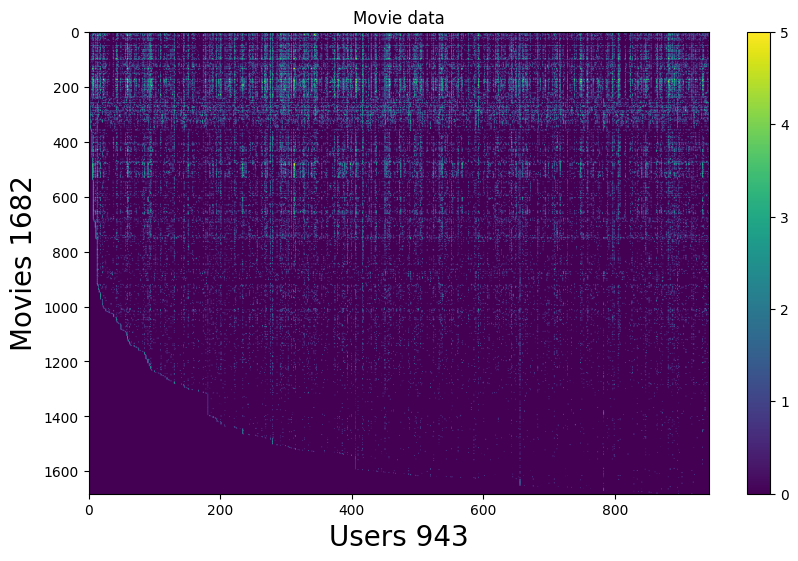

In [10]:
print(f"Average rating for movie 1: {np.mean(y[0, r[0, :]])}")
plots.plot_movie_data(y)

## Movie ratings dataset
The first part of the script ex8 cofi.m will load the dataset ex8 movies.mat, providing the variables Y and R in your Octave/MATLAB environment. The matrix Y (a num movies × num users matrix) stores the ratings $y^{(i,j)})$
(from 1 to 5). The matrix R is an binary-valued indicator matrix, where $R(i, j) = 1$ if user j gave a rating to movie i, and $R(i, j) = 0$ otherwise. The objective of collaborative filtering is to predict movie ratings for the movies that users have not yet rated, that is, the entries with $R(i, j) = 0$. This will allow us to recommend the movies with the highest predicted ratings to the user.

To help you understand the matrix Y, the script ex8 cofi.m will compute the average movie rating for the first movie (Toy Story) and output the verage rating to the screen. Throughout this part of the exercise, you will also be working with the matrices, X and Theta:

$$
X = \begin{bmatrix}
  -(x^{(1)})^T- \\
  -(x^{(2)})^T- \\
  \vdots \\
  -(x^{(n_m)})^T- \\
\end{bmatrix}
$$

$$
\Theta = \begin{bmatrix}
  -(\theta^{(1)})^T- \\
  -(\theta^{(2)})^T- \\
  \vdots \\
  -(\theta^{(u_m)})^T- \\
\end{bmatrix}
$$

The i-th row of X corresponds to the feature vector $x^{(i)}$ for the i-th movie, and the j-th row of Theta corresponds to one parameter vector $\theta^{(j)}$, for the j-th user. Both$x^{(i)}$ and $\theta^{(j)}$ are n-dimensional vectors. For the purposes of this exercise, you will use n = 100, and therefore, $x^{(i)} \in R^{100}$ and $\theta^{(j)} \in R^{100}$ . Correspondingly, X is a nm × 100 matrix and Theta is a nu × 100 matrix.

## Collaborative filtering learning algorithm
Now, you will start implementing the collaborative filtering learning algorithm. You will start by implementing the cost function (without regularization).

The collaborative filtering algorithm in the setting of movie recommendations considers a set of n-dimensional parameter vectors $x^{(1)}, ..., x^{(n_m)}$ and $\theta^{(1)} , ..., \theta^{(n_u)}$, where the model predicts the rating for movie i by user j as $y^{(i,j)} = (\theta^{(j)} )^T x^{(i)}$. Given a dataset that consists of a set of ratings produced by some users on some movies, you wish to learn the parameter vectors $x^{(1)}, ..., x^{(n_m)} , \theta^{(1)} , ...,  \theta^{(n_u)}$ that produce the best fit (minimizes the squared error).

You will complete the code in cofiCostFunc.m to compute the cost function and gradient for collaborative filtering. Note that the parameters to the function (i.e., the values that you are trying to learn) are X and Theta. In
order to use an off-the-shelf minimizer such as fmincg, the cost function has set up to unroll the parameters into a single vector params. You had previously used the same vector unrolling method in the neural networks programming exercise.

### Collaborative filtering cost function
The collaborative filtering cost function (without regularization) is given by

$$J(x^{(i)},...,x^{(n_m},\theta^{(1)},...,\theta^{(n_u)})=\frac{1}{2}\sum_{r(i,j)=1}((\theta^{(j)})^Tx^{(i)}-y^{(i,j)})^2$$

You should now modify cofiCostFunc.m to return this cost in the variable J. Note that you should be accumulating the cost for user j and movie if only if $R(i, j) = 1$. After you have completed the function, the script ex8 cofi.m will run your cost function. You should expect to see an output of 22.22.

In [11]:
x, theta = preprocessing.read_data(DATA_PATH_4, column_names=["X", "Theta"])

num_users = 4
num_movies = 5
num_features = 3

x = x[:num_movies, :num_features]
theta = theta[:num_users, :num_features]
y = y[:num_movies, :num_users]
r = r[:num_movies, :num_users]

model = algorithms.CollaborativeFilteringRegression(0)
model.theta = theta

cost = model.cost(x, y, r)
# 22.224
print(f"cost: {cost:.3f}")

cost: 22.225


## Regularized cost function
The cost function for collaborative filtering with regularization is given by

$$J(x^{(i)},...,x^{(n_m},\theta^{(1)},...,\theta^{(n_u)})=\frac{1}{2}\sum_{r(i,j)=1}((\theta^{(j)})^Tx^{(i)}-y^{(i,j)})^2 + (\frac{\lambda}{2}\sum_{j=1}^{n_u}\sum_{k=1}^{n}(\theta_k^{(j)})^2) + (\frac{\lambda}{2}\sum_{i=1}^{n_m}\sum_{k=1}^{n}(x_k^{(i)})^2)$$

You should now add regularization to your original computations of the
cost function, J. After you are done, the script ex8 cofi.m will run your
regularized cost function, and you should expect to see a cost of about 31.34.

In [12]:
model = algorithms.CollaborativeFilteringRegression(1.5)
model.theta = theta
print(x.shape, theta.shape)

cost = model.cost(x, y, r)

# 31.344
print(f"cost: {cost:.3f}")

(5, 3) (4, 3)
cost: 31.344


# Part 4

## Learning movie recommendations
After you have finished implementing the collaborative filtering cost function
and gradient, you can now start training your algorithm to make movie recommendations for yourself. In the next part of the ex8 cofi.m script, you can enter your own movie preferences, so that later when the algorithm runs, you can get your own movie recommendations! We have filled out some values according to our own preferences, but you should change this according to your own tastes. The list of all movies and their number in the dataset can be found listed in the file movie idx.txt.

In [13]:
y, r = preprocessing.read_data(DATA_PATH_3, column_names=["Y", "R"])
movies = preprocessing.read_text_file(DATA_PATH_5)
movies = preprocessing.strip_ids(movies)

## Recommendations
After the additional ratings have been added to the dataset, the script will proceed to train the collaborative filtering model. This will learn the parameters X and Theta. To predict the rating of movie i for user j, you need to compute $(\theta^{(j)})^T$. The next part of the script computes the ratings for all the movies and users and displays the movies that it recommends, according to ratings that were entered earlier in the script. Note that you might obtain a different set of the predictions due to different random initializations.

In [25]:
num_users = 4
num_movies = 5
num_features = 3
y = y[:num_movies, :num_users]
r = r[:num_movies, :num_users]

model = algorithms.CollaborativeFilteringRegression(10)
model.fit(np.random.rand(num_movies, num_features), y, r)

predictions, indices = model.top_predictions(x[0, :].reshape(1, -1))

print("Top recommendations for you:")
for i in range(len(predictions)):
    print(f"{movies[indices[i]]}")

Top recommendations for you:
Toy Story (1995)
GoldenEye (1995)
Four Rooms (1995)
Get Shorty (1995)
